In [1]:
%load_ext autoreload
%autoreload 2

import torch
from diffusers import DPMSolverMultistepScheduler
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.pipelines.sd_pipeline import SDPipeline
from text3d2video.style_aligned_attn import StyleAlignedAttentionProcessor

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

dtype = torch.float16
device = torch.device("cuda")

pipe = SDPipeline.from_pretrained(
    sd_repo, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


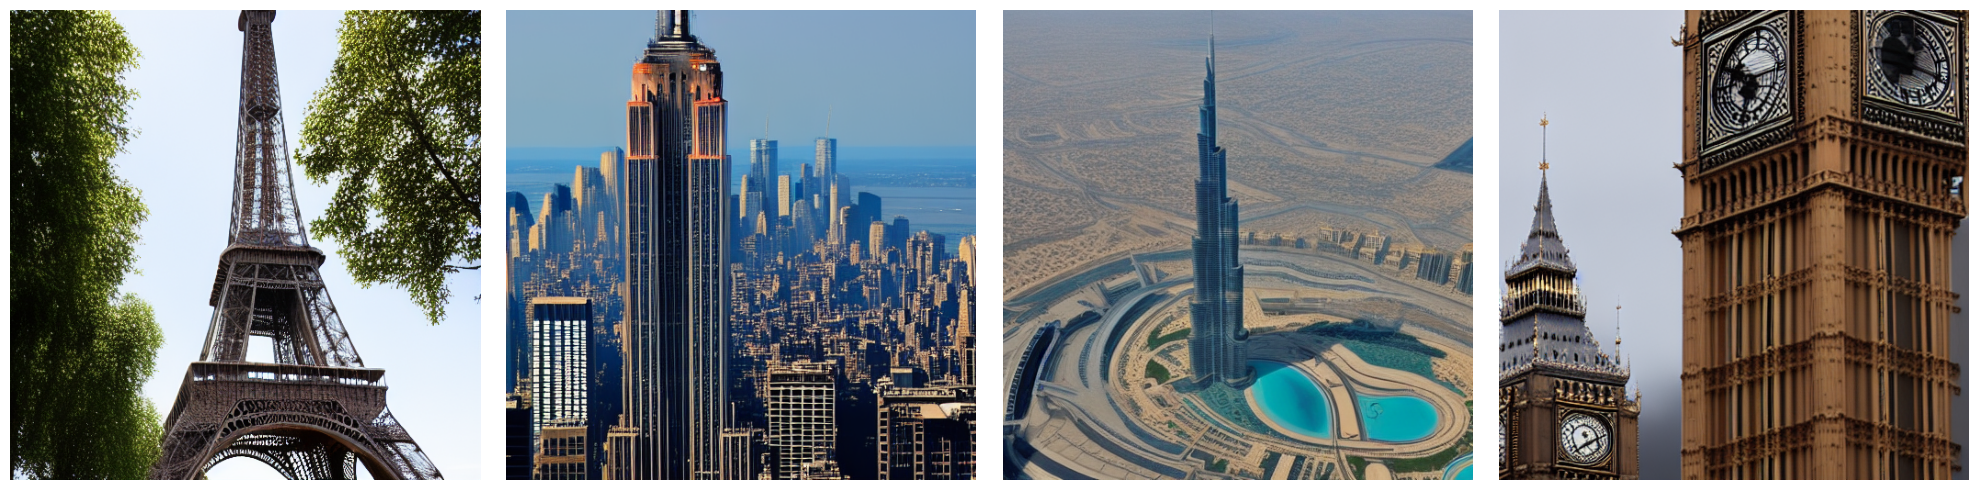

In [10]:
from text3d2video.artifacts.sd_data import SdDataConfig
from text3d2video.style_aligned_attn import DefaultAttnProcessor


prompts = ["Eiffel Tower", "Empire State", "Burj Khalifa", "Big Ben"]

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    # "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

sd_save_config = SdDataConfig(
    enabled=True,
    n_frames=5,
    n_timesteps=5,
    out_artifact="sd_data",
    module_paths=module_paths,
    save_latents=False,
    save_q=True,
    save_k=True,
    save_v=True,
)

attn_processor = StyleAlignedAttentionProcessor(
    pipe.unet, ref_index=0, attend_to="self"
)

attn_processor = DefaultAttnProcessor(pipe.unet)

pipe.unet.set_attn_processor(attn_processor)
pipe.attn_processor = attn_processor

gen = torch.Generator(device=device)
gen.manual_seed(0)

ims = pipe(prompts, sd_save_config, num_inference_steps=10, generator=gen)

display_ims(ims, scale=5)

art = pipe.data_artifact

In [12]:
from text3d2video.artifacts.sd_data import SdDataArtifact
from text3d2video.sd_feature_extraction import read_layer_paths

art: SdDataArtifact = art

frame_indices = art.diffusion_data.save_frame_indices
time_steps = art.diffusion_data.save_step_times
modules = art.diffusion_data.save_module_paths

enc_layers, mid_layers, dec_layers = read_layer_paths(modules)

# print_datasets(art.h5_file_path())

In [21]:
from text3d2video.utilities.attention_visualization import split_heads

layer = dec_layers[-1]
module = layer.module_path()

frame = frame_indices[1]
time = time_steps[2]

# get features
key = art.attn_writer.read_key(time, frame, module)
qry = art.attn_writer.read_qry(time, frame, module)
val = art.attn_writer.read_val(time, frame, module)

# for a particular head
key_mh = split_heads(key.unsqueeze(0))
qry_mh = split_heads(qry.unsqueeze(0))
val_mh = split_heads(val.unsqueeze(0))
head_idx = 2
key_head = key_mh[0, :, head_idx, :]
qry_head = qry_mh[0, :, head_idx, :]
val_head = val_mh[0, :, head_idx, :]

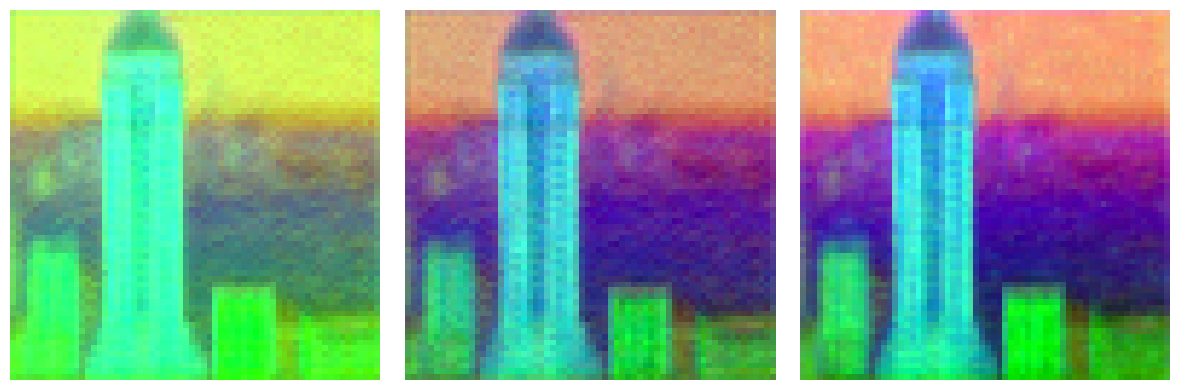

torch.Size([40, 64, 64])
tensor(-0.4847)
tensor(-0.9085)
tensor(-0.9085)


In [22]:
from einops import rearrange

from text3d2video.adain import adain_2D
from text3d2video.feature_visualization import RgbPcaUtil


res = layer.layer_resolution(pipe.unet)
qry_square = rearrange(qry_head, "(h w) c -> c h w", h=res)
key_square = rearrange(key_head, "(h w) c -> c h w", h=res)

qry_adain = adain_2D(qry_square.unsqueeze(0), key_square.unsqueeze(0))[0]

pca = RgbPcaUtil.init_from_features(key_head)

qry_pca = pca.feature_map_to_rgb_pil(qry_square)
qry_adain_pca = pca.feature_map_to_rgb_pil(qry_adain)
key_pca = pca.feature_map_to_rgb_pil(key_square)
display_ims([qry_pca, qry_adain_pca, key_pca], scale=4)

print(qry_adain.shape)

print(qry_square[0].mean())
print(qry_adain[0].mean())
print(key_square[0].mean())